In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold

import time

In [3]:

wine_df = pd.read_csv("data/winequalityN.csv")
wine_df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
cleanup_wines = {"type":     {"white": 0, "red": 1}
                }
wine_df.replace(cleanup_wines,inplace = True)
wine_df = wine_df.dropna()

In [5]:
target = wine_df['quality']
target[target < 6] = 0
target[target >= 6] = 1
wine_df.drop( ['quality'],axis = 1,inplace = True)

/Users/harshsikka/opt/anaconda3/envs/CS-7641-A1/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
X_train,X_test,Y_train,Y_test = train_test_split(wine_df, target, random_state=42)

In [7]:
print(len(X_train))
print(len(Y_train))
print(len(X_test))
print(len(Y_test))

4847
4847
1616
1616


In [8]:
target.value_counts()

1    4091
0    2372
Name: quality, dtype: int64

In [9]:
sc=StandardScaler()
sc.fit(X_train)
X_train_std=sc.transform(X_train)
X_test_std=sc.transform(X_test)

/Users/harshsikka/opt/anaconda3/envs/CS-7641-A1/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/harshsikka/opt/anaconda3/envs/CS-7641-A1/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/harshsikka/opt/anaconda3/envs/CS-7641-A1/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


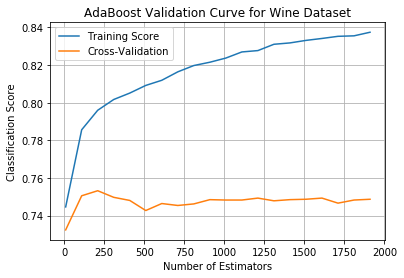

In [11]:
from sklearn import tree
boosted_classifier = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=1, min_samples_leaf=1, random_state=42), n_estimators=1500, random_state=42)
train_scores, test_scores = validation_curve(boosted_classifier, X_train, Y_train, param_name="n_estimators", param_range=np.arange(10,2000,100), cv=5,
                                            n_jobs=4)

avg_train_score, avg_test_score = np.mean(train_scores, axis=1), np.mean(test_scores, axis=1)
plt.figure()
plt.plot(np.arange(10,2000,100), avg_train_score, label='Training Score')
plt.plot(np.arange(10,2000,100), avg_test_score, label='Cross-Validation')


plt.title('AdaBoost Validation Curve for Wine Dataset')
plt.xlabel('Number of Estimators')
plt.ylabel("Classification Score")
plt.legend()
plt.grid()
plt.show()

In [12]:
best_boosted_classifier = GridSearchCV(boosted_classifier, param_grid={'n_estimators' : np.arange(100,300,5)}, cv=5, n_jobs=4)
train_t0 = time.time()
best_boosted_classifier.fit(X_train, Y_train)
train_t1 = time.time()
t0 = time.time()
prediction = best_boosted_classifier.predict(X_test)
t1 = time.time()

print('Train Time: ', train_t1 - train_t0)
print('Test Time: ', t1 - t0)
print('Top Accuracy:', (accuracy_score(Y_test, prediction) * 100))
print('Top params: ', best_boosted_classifier.best_params_)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, prediction))

Train Time:  42.41521906852722
Test Time:  0.04498410224914551
Top Accuracy: 75.99009900990099
Top params:  {'n_estimators': 215}
[[374 230]
 [158 854]]


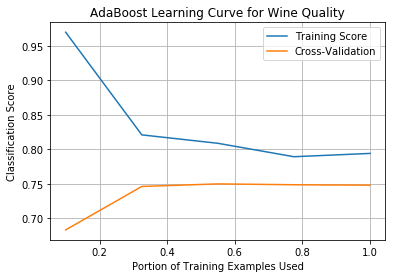

In [13]:
train_sizes, train_scores, test_scores = learning_curve(best_boosted_classifier, X_train, Y_train, train_sizes=np.linspace(0.1, 1.0, 5), cv=5, n_jobs=4)
avg_train_score, avg_test_score = np.mean(train_scores, axis=1), np.mean(test_scores, axis=1)
plt.figure()
plt.plot(train_sizes/train_sizes[-1], avg_train_score, label='Training Score')
plt.plot(train_sizes/train_sizes[-1], avg_test_score, label='Cross-Validation')
plt.title('AdaBoost Learning Curve for Wine Quality')
plt.xlabel('Portion of Training Examples Used')
plt.ylabel("Classification Score")
plt.legend()
plt.grid()
plt.show()